# SARIMA test
The final polished implementation of:

ARIMA (Auto Regression Integrated Moving Average)
and 
SARIMA (Seasonal Auto Regression Integrated Moving Average)

<br>This jupyter notebook contains the following functionalities:
<br>Data Preprocessing:
<br>    1.Load the Json file data.
<br>    2.Fetch timestamp and corresponding value from Json file.
<br>    2.Convert the dataframe into timeseries.
<br>    3.Compress the timeseries into (1h/ 0.5h/ 0.25/)

Implementation of SARIMA

In [1]:
import os
import time
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import math

import json as JS
from json import load
from json import loads
from datetime import datetime
#from fbprophet import Prophet

from pmdarima.arima import auto_arima
import statsmodels.api as sm
import mlflow
import mlflow.sklearn
from itertools import product

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import pandas as pd
from pandas.io.json import json_normalize
from pandas.plotting import autocorrelation_plot
from pandas.plotting import register_matplotlib_converters

In [2]:
# required package: sklearn
# pip3 install -U scikit-learn scipy matplotlib
# pip3 install statsmodels
# pip3 install pyramid-arima

In [14]:
def process_data(data, freq):
    values_col = data["values"]
    new = []
    for x in values_col:
         for y in x:
             y[0] = datetime.fromtimestamp(y[0])
             y[1] = float(y[1])

         new = new + x

    values_col = pd.DataFrame(new)
    values_col.rename(columns = {0: 'Date'}, inplace = True)
    values_col['datetime'] = pd.to_datetime(values_col['Date'])
    values_col= values_col.set_index('datetime')
    values_col.drop(['Date'], axis = 1, inplace = True)
    values_col.rename(columns = {1: 'value'}, inplace = True)
    values_col = values_col.resample(freq).mean()
    values_col = values_col.dropna()      
    return values_col

In [15]:
def split_data(dataframe):
    #randomly choose up to 80% of the data as training data.
    dataframe = dataframe.sort_values(by = 'datetime')
    ratio = 0.2
    size = int(len(dataframe) * (1-float(ratio)))
    train, test = dataframe[0:size], dataframe[size:len(dataframe)]
    return train, test

In [16]:
def sarima_driver(dataframe, freq):
    train,test = split_data(dataframe)
    forecast = _sarima(dataframe, train, test, freq)
    # _mlflow_sarima(train,test)
    return forecast, test

In [33]:
def _sarima(train, test, freq):
    sfrequency = 0
    if freq == '1h':
        sfrequency = 24
    elif freq == '30Min':
        sfrequency = 48
    elif freq == '15Min':
        sfrequency = 96
        
    model = SARIMAX(train, order=(1, 2, 2), seasonal_order=(2,2,2,sfrequency), enforce_stationarity = True, enforce_invertibility = False)
    model_fit = model.fit(dsip=-1)
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot()
    print("Now plotting the residual errors for the SARIMA model")
    plt.show()
    residuals.plot(kind='kde')
    print("Now plotting the desity of the residual error values.")
    plt.show()
    print(residuals.describe())
    K = len(test)

    forecast = model_fit.forecast(K)
    # forecast = np.exp(forecast)
    forecast = pd.DataFrame(forecast.values, columns = ['predict'], index = test.index)

    plt.plot(forecast, label='forecast')
    plt.show()
    plt.figure(figsize=(12,5), dpi=100)
    # plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(forecast, label='forecast')
    # plt.title('RMSE: %.2f'% np.sqrt(sum((forecast-test)**2)/len(test)))
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    return model, model_fit, forecast

In [40]:
def evaluation(forecast, test):
    upper_bound = np.array(
      [
        (
         float(np.ma.average(forecast[:i], axis = 0,weights=np.linspace(0, 1, num=len(forecast[:i]))))
          + (np.std(forecast[:i]) * 2)
        )
        for i in range(len(forecast))
        ]
    )
      # to account for no std of a single value
    lower_bound = np.array(
      [
        (
          float(np.ma.average(
            forecast[:i],axis = 0,
            weights=np.linspace(0, 1, num=len(forecast[:i])),))
          - (np.std(forecast[:i]) * 2)
        )
        for i in range(len(forecast))
        ]
    )

    compare = test.join(forecast, how = 'outer')
    compare = compare.dropna()
    lower = pd.DataFrame(lower_bound, columns = [0], index = test.index)
    upper = pd.DataFrame(upper_bound, columns = [0], index = test.index)

    compare.insert(2, "LowerBound", lower, True)
    compare.insert(3, "UpperBound", upper, True)
    compare['LessThan'] = compare['predict'] < compare['UpperBound']
    compare['MoreThan'] = compare['predict'] > compare['LowerBound']
    compare['Within Bound (Not Anomaly)']= compare['LessThan'] == compare['MoreThan']
    print("The final dataframe with lowerbound, upperbound and prediction value:\n")
    print(compare)

    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(compare['predict'], label='forecast')
    plt.plot(compare['LowerBound'], label='LowerBound')
    plt.plot(compare['UpperBound'], label='UpperBound')
    plt.plot(compare['value'], label='Test')
    # plt.title('RMSE: %.2f'% np.sqrt(sum((forecast-test)**2)/len(test)))
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [30]:
data = pd.read_json("w90days.json")
freq = '1h'
processed_data = process_data(data, freq)
train, test = split_data(processed_data)

In [31]:
print(train)

                         value
datetime                      
2019-07-10 15:00:00   0.000000
2019-07-10 16:00:00   0.027417
2019-07-10 17:00:00   7.269352
2019-07-10 18:00:00   4.570231
2019-07-10 19:00:00  11.845331
...                        ...
2019-09-09 20:00:00  56.355619
2019-09-09 21:00:00  28.033826
2019-09-09 22:00:00   0.040285
2019-09-09 23:00:00   0.024829
2019-09-10 00:00:00   0.023917

[1474 rows x 1 columns]


/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Now plotting the residual errors for the SARIMA model


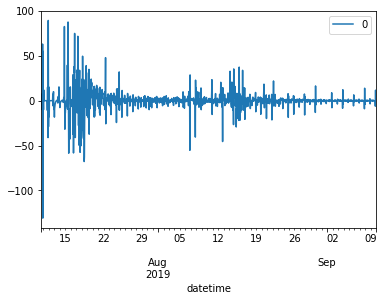

Now plotting the desity of the residual error values.


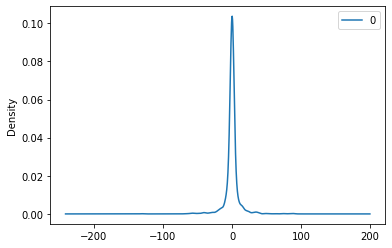

                 0
count  1474.000000
mean      0.101036
std      10.906336
min    -130.947097
25%      -1.174013
50%       0.074911
75%       1.275414
max      89.453313


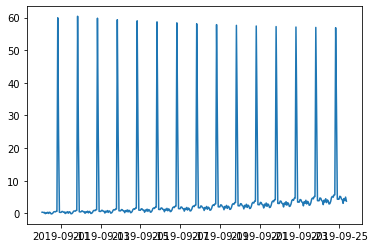

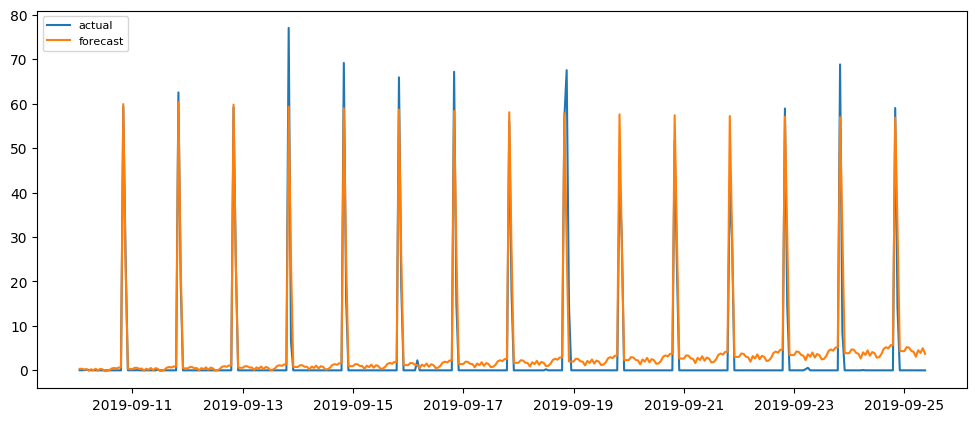

In [34]:
model, model_fit, forecast = _sarima(train, test, freq)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Warning: converting a masked element to nan.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.


The final dataframe with lowerbound, upperbound and prediction value:

                        value   predict  LowerBound  UpperBound  LessThan  \
datetime                                                                    
2019-09-10 01:00:00  0.025312  0.332728         NaN         NaN     False   
2019-09-10 02:00:00  0.027993  0.357123         NaN         NaN     False   
2019-09-10 03:00:00  0.039052  0.195425    0.332728    0.381519      True   
2019-09-10 04:00:00  0.122933  0.294969    0.106973    0.391676      True   
2019-09-10 05:00:00  0.105329 -0.101328    0.148866    0.395427      True   
...                       ...       ...         ...         ...       ...   
2019-09-25 05:00:00  0.000000  3.066461  -18.323294   30.431258      True   
2019-09-25 06:00:00  0.000000  4.526806  -18.307312   30.382536      True   
2019-09-25 07:00:00  0.006667  3.925276  -18.282401   30.341113      True   
2019-09-25 08:00:00  0.006190  4.984866  -18.261107   30.296887      True   
2019-

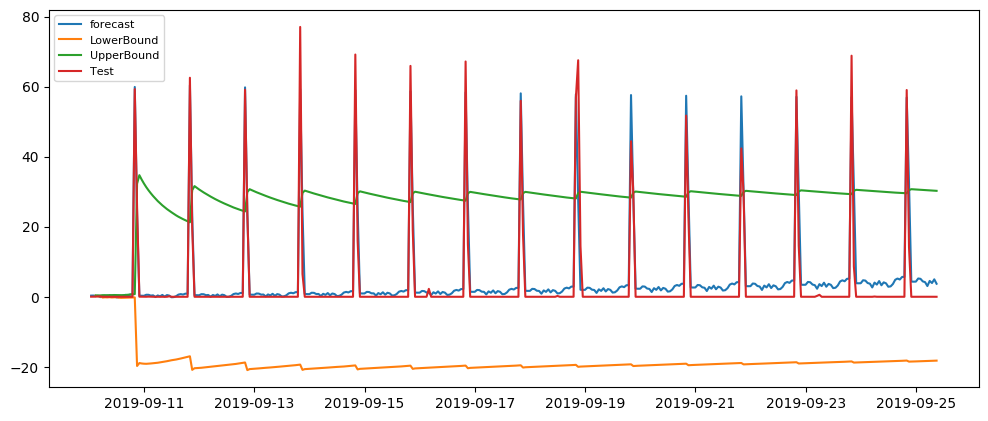

In [41]:
evaluation(forecast, test)